In [1]:
# Testing the generalization performance of the soft exponential function for extrapolation
# "A continuum among logarithmic, linear, and exponential functions, and its potential to improve generalization in neural networks"
# Luke B. Godfrey, Michael S. Gashler
# http://arxiv.org/abs/1602.01321

%pylab inline

import numpy as np
import pandas as pd

import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX880M (CNMeM is disabled, cuDNN not available)


In [2]:
def softExp(x,a):
    return (a<0)*(-T.log(1+abs(a)*(1e-16 + abs(x)-abs(a)))/(abs(a)+1e-16)) + \
           (a>0)*((T.exp(abs(a)*x)-1)/(abs(a)+1e-16)+a) + \
           T.eq(a,0)*x

class PSoftExpLayer(lasagne.layers.MergeLayer):
    def __init__(self, incomings, **kwargs):
        super(PSoftExpLayer, self).__init__(incomings, **kwargs)

    def get_output_for(self, inputs, **kwargs):
        return softExp(inputs[0], inputs[1])

    def get_output_shape_for(self, input_shape):
        return input_shape[0]

In [3]:
# Noisy parabola thing in 1D
def getLabel(x):
    return ((0.5+x[:,0])**2)*(0.8 + 0.4*np.random.rand(x.shape[0]))

train = np.random.rand( 10000, 1 )*1
test = np.random.rand( 10000, 1 )*10

trlabels = getLabel(train)
tslabels = getLabel(test)

# First, a standard dense network with ReLU to see how it works
def buildBaseNet():
    invar = T.matrix()
    targ = T.vector()
    
    input = lasagne.layers.InputLayer(shape=(None,1), input_var = invar)
    dense1 = lasagne.layers.DenseLayer(input, num_units = 20)
    dense2 = lasagne.layers.DenseLayer(dense1, num_units = 20)
    dense3 = lasagne.layers.DenseLayer(dense2, num_units = 1, nonlinearity = None)
        
    out = lasagne.layers.get_output(dense3)
    params = lasagne.layers.get_all_params(dense3, trainable=True)
    loss = T.mean( (out[:,0]-targ)**2 )
    
    updates = lasagne.updates.adam(loss,params,learning_rate = 1e-2)
    train = theano.function([invar, targ], loss, updates=updates,allow_input_downcast=True)
    test = theano.function([invar, targ],loss,allow_input_downcast=True)
    process = theano.function([invar],out,allow_input_downcast=True)
    return train,test,process

train_base, test_base, process_base = buildBaseNet()

In [4]:
for epoch in range(100):
    trerr = train_base(train, trlabels)
    tserr = test_base(test, tslabels)
    
    if epoch%10 == 0:
        print "%.6g, %.6g" % (trerr, tserr)

1.63791, 2633.09
0.14145, 1974.01
0.0956823, 1996.95
0.0908737, 1944.44
0.0572628, 1744.36
0.0339218, 1720.35
0.0248888, 1594.58
0.0228169, 1572.34
0.0224198, 1531.46
0.0219695, 1535.42


In [5]:
tr_y = process_base(train)
ts_y = process_base(test)

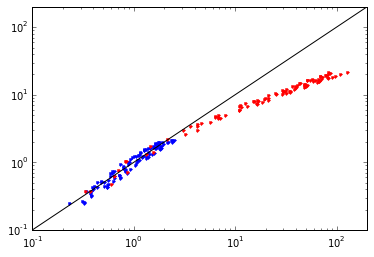

In [6]:
# True label vs prediction, see if it generalizes at large x?

plt.plot(trlabels[::100],tr_y[::100],'b.')
plt.plot(tslabels[::100],ts_y[::100],'r.')
plt.plot(np.arange(1000), np.arange(1000), 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,2e2)
plt.ylim(1e-1,2e2)
plt.show()

In [7]:
# This network just has trained parameters for the function

def buildSMNet():
    invar = T.matrix()
    targ = T.vector()
    Z = T.zeros((10000,20))
    Z2 = T.zeros((10000,1))
    
    input = lasagne.layers.InputLayer(shape=(None,1), input_var = invar)
    Zinp = lasagne.layers.InputLayer(shape=(None,20), input_var = Z)
    Zinp2 = lasagne.layers.InputLayer(shape=(None,1), input_var = Z2)
    
    dense1 = lasagne.layers.DenseLayer(input, num_units = 20, nonlinearity = None)
    bias1 = lasagne.layers.BiasLayer(Zinp)
    
    ps1 = PSoftExpLayer([dense1,bias1])
    
    dense2 = lasagne.layers.DenseLayer(ps1, num_units = 1, nonlinearity = None)
    bias2 = lasagne.layers.BiasLayer(Zinp2)
    
    ps2 = PSoftExpLayer([dense2,bias2])
        
    out = lasagne.layers.get_output(ps2)
    params = lasagne.layers.get_all_params(ps2, trainable=True)
    loss = T.mean( (out[:,0]-targ)**2 )
    
    updates = lasagne.updates.adam(loss,params,learning_rate = 1e-2)
    train = theano.function([invar, targ], loss, updates=updates,allow_input_downcast=True)
    test = theano.function([invar, targ],loss,allow_input_downcast=True)
    process = theano.function([invar],out,allow_input_downcast=True)
    return train,test,process

train_sm, test_sm, process_sm = buildSMNet()

In [8]:
for epoch in range(100):
    trerr = train_sm(train, trlabels)
    tserr = test_sm(test, tslabels)
    
    if epoch%10 == 0:
        print "%.6g, %.6g" % (trerr, tserr)

0.816905, 2266.05
0.0966834, 1780.92
0.0530169, 1805.35
0.0532691, 1815.88
0.0328109, 1692.55
0.0277398, 1673.77
0.0268206, 1650.96
0.0262329, 1618.34
0.0260072, 1620.26
0.0259499, 1612.13


In [9]:
tr_y = process_sm(train)
ts_y = process_sm(test)

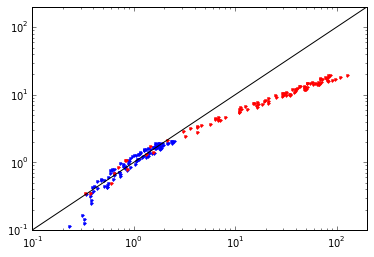

In [10]:
plt.plot(trlabels[::100],tr_y[::100],'b.')
plt.plot(tslabels[::100],ts_y[::100],'r.')
plt.plot(np.arange(1000), np.arange(1000), 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,2e2)
plt.ylim(1e-1,2e2)
plt.show()

In [11]:
# This network uses the output of a layer to determine the parameters for the function

def buildSM2Net():
    invar = T.matrix()
    targ = T.vector()
    
    input = lasagne.layers.InputLayer(shape=(None,1), input_var = invar)
    
    dense1 = lasagne.layers.DenseLayer(input, num_units = 20, nonlinearity = None)
    dense1b = lasagne.layers.DenseLayer(input, num_units = 20, nonlinearity = lasagne.nonlinearities.tanh)
    
    ps1 = PSoftExpLayer([dense1,dense1b])
    
    dense2 = lasagne.layers.DenseLayer(ps1, num_units = 1, nonlinearity = None)
    dense2b = lasagne.layers.DenseLayer(ps1, num_units = 1, nonlinearity = lasagne.nonlinearities.tanh)
    
    ps2 = PSoftExpLayer([dense2,dense2b])
        
    out = lasagne.layers.get_output(ps2)
    params = lasagne.layers.get_all_params(ps2, trainable=True)
    loss = T.mean( (out[:,0]-targ)**2 )
    
    updates = lasagne.updates.adam(loss,params,learning_rate = 1e-4)
    train = theano.function([invar, targ], loss, updates=updates,allow_input_downcast=True)
    test = theano.function([invar, targ],loss,allow_input_downcast=True)
    process = theano.function([invar],out,allow_input_downcast=True)
    return train,test,process

train_sm2, test_sm2, process_sm2 = buildSM2Net()

In [12]:
# Needs a lot more because this is super-unstable, so have to use a tiny tiny learning rate...

for epoch in range(1000):
    trerr = train_sm2(train, trlabels)
    tserr = test_sm2(test, tslabels)
    
    if epoch%10 == 0:
        print "%.6g, %.6g" % (trerr, tserr)

1.42769, 2707.67
1.37146, 2688.64
1.31852, 2674.86
1.26727, 2672.56
1.21794, 2666.2
1.17024, 2659.04
1.12416, 2654.04
1.08779, 2647.53
1.04029, 2641.61
0.998016, 2634.05
0.957422, 2629.5
0.9189, 2624.47
0.889137, 2621.74
0.848043, 2615.94
0.815401, 2612.01
0.780165, 2607.07
0.750114, 2605.25
0.714153, 2598.89
0.683411, 2588.76
0.66285, 2584.27
0.634478, 2578.19
0.606138, 2571.53
0.576666, 2570.6
0.549143, 2565.95
0.519476, 2558.78
0.494672, 2546.91
0.479044, 2537.11
0.447924, 2528.15
0.433417, 2516.91
0.40438, 2520.27
0.383545, 2509.17
0.363347, 2500.63
0.343876, 2486.77
0.325179, 2473.09
0.307311, 2469.38
0.290267, 2452.24
0.273911, 2436.63
0.258399, 2422.35
0.243677, 2411.47
0.229686, 2395.17
0.216553, 2387.06
0.20404, 2361.94
0.192349, 2347.87
0.181284, 2330.43
0.170878, 2330.1
0.176671, 2315.3
0.152464, 2298.18
0.154749, 2277.82
0.136467, 2282.49
0.137537, 2279.25
0.128947, 2270.9
0.120486, 2262.28
0.111448, 2246.07
0.10629, 2239.96
0.101539, 2235.75
0.0973026, 2232.73
0.0935182, 2

In [13]:
tr_y = process_sm2(train)
ts_y = process_sm2(test)

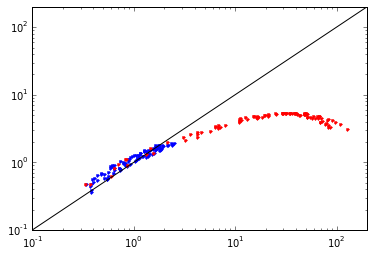

In [14]:
plt.plot(trlabels[::100],tr_y[::100],'b.')
plt.plot(tslabels[::100],ts_y[::100],'r.')
plt.plot(np.arange(1000), np.arange(1000), 'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,2e2)
plt.ylim(1e-1,2e2)
plt.show()